<a href="https://www.pieriandata.com"><img src="../DATA/Logo.jpg"></a>
*Copyright by Pierian Data Inc.*

# Feature Matching

In [203]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [164]:
def display(img,cmap='gray'):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap='gray')

In [165]:
reeses = cv2.imread('../DATA/reeses_puffs.png',0)     

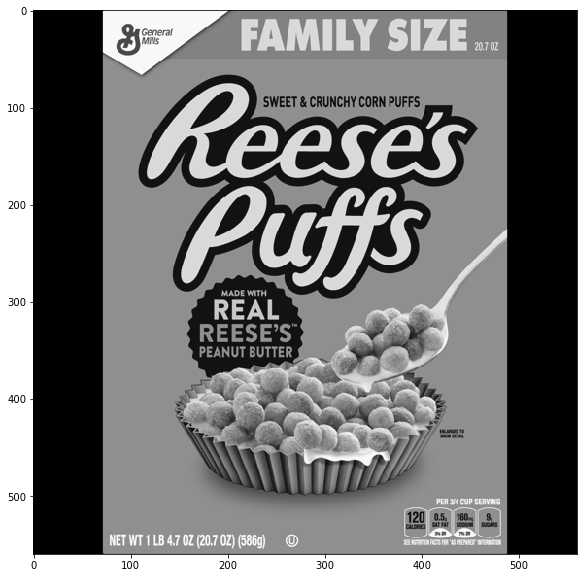

In [192]:
display(reeses)

In [194]:
cereals = cv2.imread('../DATA/many_cereals.jpg',0) 

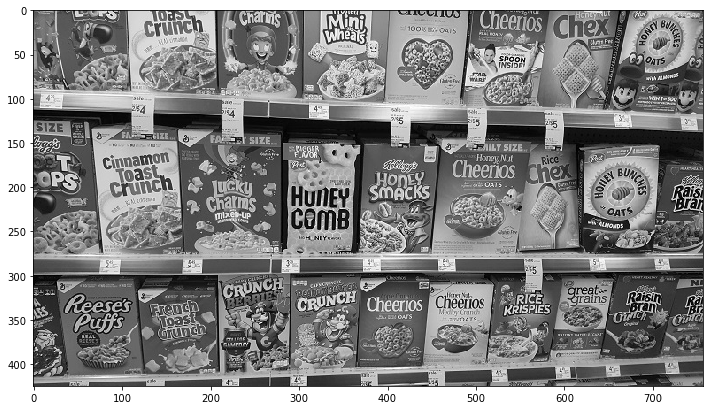

In [195]:
display(cereals)

--------
# Brute Force Detection with ORB Descriptors

In [169]:
# Deteccion de fuerza bruta
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
# Puntos claves y descriptores 
kp1, des1 = orb.detectAndCompute(reeses,None)
kp2, des2 = orb.detectAndCompute(cereals,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors. Macheos
matches = bf.match(des1,des2)

#Cuando menor distancia hay, mejor fue
print(matches[0].distance)

# Sort them in the order of their distance.
# Clasificamos por orden de distancia
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 25 matches.
# Elegimos las primeras 25, como esta ordenado seran las mejores coincidencias
reeses_matches = cv2.drawMatches(reeses,kp1,cereals,kp2,matches[:25],None,flags=2)

78.0


In [170]:
temp_match = matches[1]
temp_match.trainIdx

240

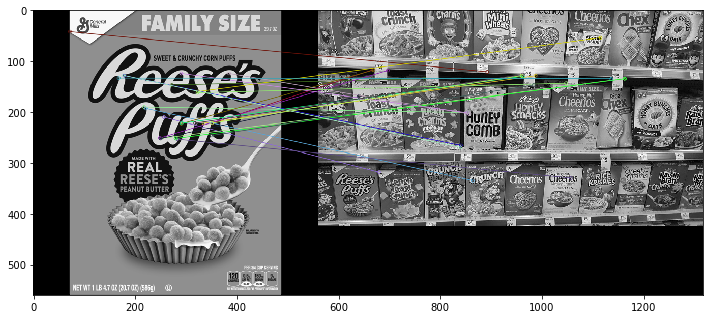

In [171]:
display(reeses_matches)

# Brute-Force Matching with SIFT Descriptors and Ratio Test

In [259]:
# pip install opencv-python==3.4.2.16
# pip install opencv-contrib-python==3.4.2.16

# Create SIFT Object
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(reeses,None)
kp2, des2 = sift.detectAndCompute(cereals,None)

# BFMatcher with default params, k las 2 mejores coincidencias
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

#genera 2 por cada uno, el primero es mejor que el segundo
print(len(matches[0]))
print(matches[0][0].distance)
print(matches[0][1].distance)
# Apply ratio test
good = []
bad = []
for match1,match2 in matches: #, match3 in matches:
    # si los 2 estan muy lejos probablemente no sea buena prediccion, siempre la 1 va a ser menos a la 2 
    # Menor distancia mejor metrica
    # Si la distancia 1 es menor al 75% de la distancia 2
    if match1.distance < 0.75*match2.distance: #and match2.distance < 0.99*match3.distance:
        #print(match1.distance)
        #print(match2.distance)
        #print('\n')
        good.append([match1])
    else:
        bad.append([match1])

# cv2.drawMatchesKnn expects list of lists as matches.
# Pasamos ademas la lista de buenas coincidencias
sift_matches = cv2.drawMatchesKnn(reeses,kp1,cereals,kp2,good,None,flags=2)

2
277.8704833984375
294.15472412109375


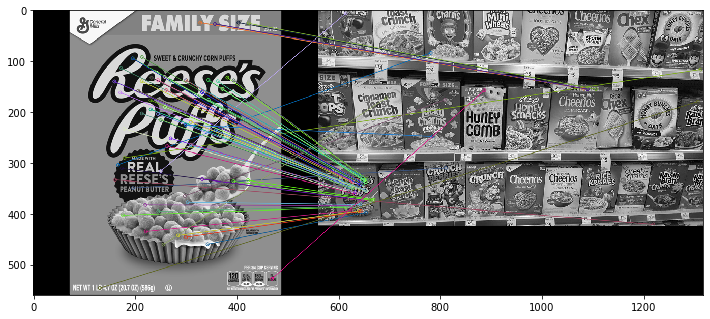

In [260]:
# Encontro algunas que decia family size
display(sift_matches)

# FLANN based Matcher

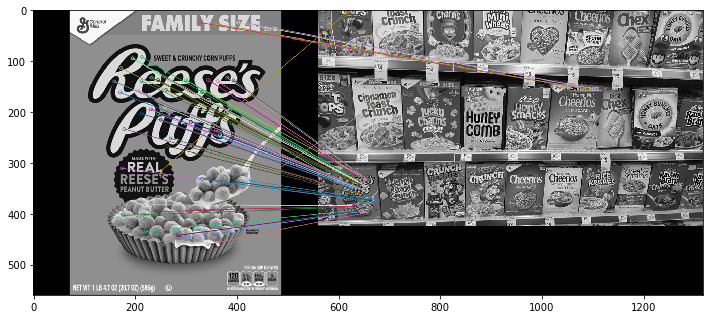

In [268]:
# Initiate SIFT detector
# Es mas rapido pero no va a encontrar las mejores coincidencias
# trabaja con vecinos maa cercanos
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(reeses,None)
kp2, des2 = sift.detectAndCompute(cereals,None)

# FLANN parameters
# Esto lo puede hacer mas lento o mas rapido, a medida que vayamos jugando con los parametros
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)  

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

good = []

# ratio test
for i,(match1,match2) in enumerate(matches):
    if match1.distance < 0.7*match2.distance:
        
        good.append([match1])


flann_matches = cv2.drawMatchesKnn(reeses,kp1,cereals,kp2,good,None,flags=2)

display(flann_matches)

In [247]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(reeses,None)
kp2, des2 = sift.detectAndCompute(cereals,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)  

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]


# ratio test
for i,(match1,match2) in enumerate(matches):
    if match1.distance < 0.7*match2.distance:
        matchesMask[i]=[1,0]

# flag = 0, porque muestra todos los puntos
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)
# Pasamos todos los macheos (matches)
flann_matches = cv2.drawMatchesKnn(reeses,kp1,cereals,kp2,matches,None,**draw_params)

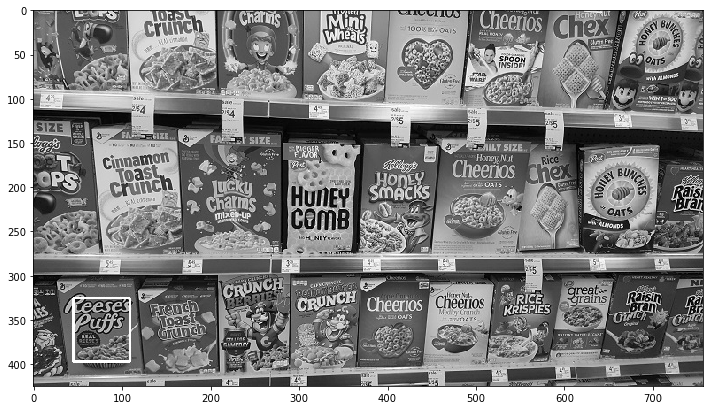

In [248]:
good = []


for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
len(good)

src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

#print(dst_pts[mask==1])
pts = dst_pts[mask==1]
min_x, min_y = np.int32(pts.min(axis=0))
max_x, max_y = np.int32(pts.max(axis=0))
img = cv2.rectangle(cereals.copy(),(min_x, min_y), (max_x,max_y), 255,2)
display(img)

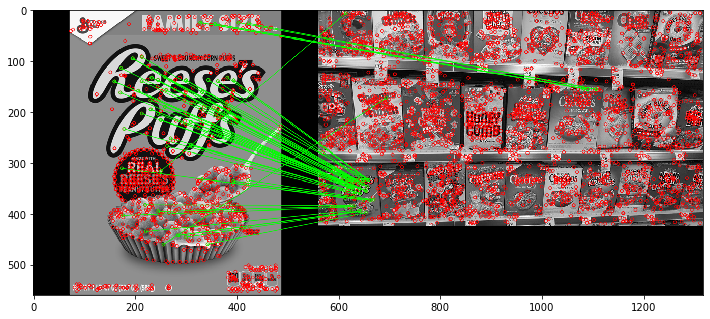

In [249]:
display(flann_matches)